In [6]:
from apply_makeup import *
from detect_features import *
a = ApplyMakeup()
output = a.apply_lipstick("face2.jpg",10,250,20)

In [25]:
import itertools
import scipy.interpolate
import numpy as np
from skimage import color
import os.path
import sys
import cv2
import dlib
import matplotlib.pyplot as plt
import re
%matplotlib inline

height: 490 width 850


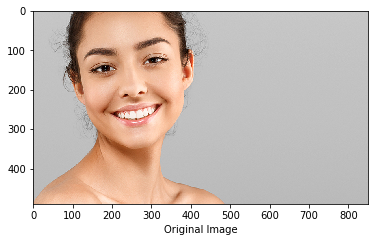

In [380]:
# read the image
ori = cv2.imread("face2.jpg")
img = ori.copy()
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.xlabel("Original Image")
plt.imshow(img)
height,width = img.shape[:2]
print("height:",height,"width",width)

111 52 379 320


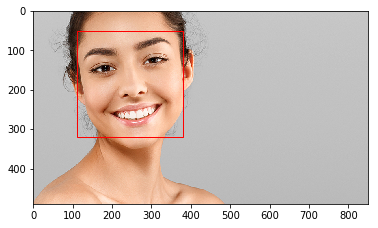

In [185]:
# face detection to get rect -> face landmark extract
PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat" # face landmark detector model path
CASC_PATH = "haarcascade_frontalface_default.xml"  # path to haar face detector model path

predictor = dlib.shape_predictor(PREDICTOR_PATH)
#cascade = cv2.CascadeClassifier(CASC_PATH)
detector = dlib.get_frontal_face_detector() # return a rectangle for face detection (left,right,top,bottom)

landmarks = []
try:
    rects = detector(img, 1)   # use 
    size = len(rects)
    if size == 0:
        print("No face found in the image")
    else:
        landmarks = numpy.matrix([[p.x, p.y] for p in predictor(img, rects[0]).parts()])
except Exception:
    print("Exception Occur")

    
index = re.sub("[\[\]\(\),]","",str(rects[0])).split()
index = [int(a) for a in index]
offset = index[2]-index[0]
plt.imshow(img)
print(index[0],index[1],index[2],index[3])
plt.gca().add_patch(plt.Rectangle((index[0],index[1]),offset,offset,linewidth=1,edgecolor='r',facecolor='none'))

In [72]:
# get lips points
lips = []
for point in landmarks[48:]:   # lips points start from no. 48 
    a,b = str(point).replace('[', '').replace(']', '').split()
    lips.append([int(a),int(b)])
    
# flatten the points
lips_points = [item for sublist in lips for item in sublist]

In [81]:
# Get the points that decribe Upper/Lower lips Upper/Lower bounds
uol = [] # sequential points of Upper Lips Upper bound left to right
uil = [] # sequential points of Lower Lips Lower bound right to left
lol = [] # sequential points of Upper lips Lower bound left to right
lil = [] # sequential points of Lower Lips Upper bound right to left

for i in range(0, 14, 2):  #point 49~55 Upper bound of upper lips
    uol.append([int(lips_points[i]), int(lips_points[i + 1])])

for i in range(12, 24, 2): #point 55~60 Lower bound of lower lips
    lol.append([int(lips_points[i]), int(lips_points[i + 1])])
lol.append([int(lips_points[0]), int(lips_points[1])]) # add the leftmost point back to balance the curve

for i in range(24, 34, 2): #point 61~65 Lower bound of Upper lips
    uil.append([int(lips_points[i]), int(lips_points[i + 1])])

for i in range(32, 40, 2): #point 65~68 Upper bound of Lower lips
    lil.append([int(lips_points[i]), int(lips_points[i + 1])])
lil.append([int(lips_points[24]), int(lips_points[25])]) # add the leftmost points(61) back to balance the curve

In [308]:
# Get the curve of lips with lips point by interpolation
#debug = 1
def __draw_curve(points,lips="upper"):
    """ Draws a curve alone the given points by creating an interpolated path. """
    x_pts = []
    y_pts = []
    curvex = []
    curvey = []
    debug = 3
    for point in points:
        x_pts.append(point[0])
        y_pts.append(point[1])
    curve = scipy.interpolate.interp1d(x_pts, y_pts, 'linear') # linear, quadraric, cubic approximation
    if lips=="upper":
        for i in np.arange(x_pts[0], x_pts[-1] + 1, 1):
            curvex.append(i)
            curvey.append(int(curve(i)))
    else:
        for i in np.arange(x_pts[len(x_pts) - 1] + 1, x_pts[0], 1):
            curvex.append(i)
            curvey.append(int(curve(i)))
    return curvex, curvey

uol_curve = __draw_curve(uol)
uil_curve = __draw_curve(uil)
lol_curve = __draw_curve(lol,"lower")
lil_curve = __draw_curve(lil,"lower")

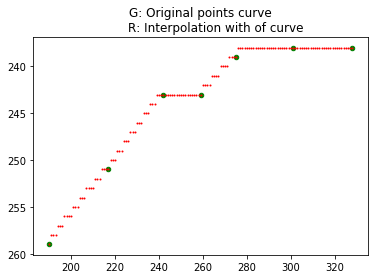

In [309]:
plt.scatter(np.array(uol)[:,0],np.array(uol)[:,1],20,color='g')
plt.scatter(uol_curve[0],uol_curve[1],1,color='r')
plt.gca().invert_yaxis()
plt.title("""G: Original points curve
        R: Interpolation with of curve""")
plt.show()

In [310]:
def fill_lip_lines(outer, inner):
        lip_x=[]
        lip_y=[]
        """ Fills the outlines of a lip with colour. """
        outer_curve = zip(outer[0], outer[1])
        inner_curve = zip(inner[0], inner[1])
        count = len(inner[0]) - 1
        last_inner = [inner[0][count], inner[1][count]]
        for o_point, i_point in itertools.zip_longest(
                outer_curve, inner_curve, fillvalue=last_inner
            ):
            line = scipy.interpolate.interp1d(
                [o_point[0], i_point[0]], [o_point[1], i_point[1]], 'linear')
            xpoints = list(np.arange(o_point[0], i_point[0], 1))
            lip_x.extend(xpoints)
            lip_y.extend([int(point) for point in line(xpoints)])
        return lip_x, lip_y

In [368]:
def add_color(image,intensity,lip_x,lip_y,rgb=(10,170,10)):
        """ Adds base colour to all points on lips, at mentioned intensity. """
        red_l,green_l,blue_l = rgb
        
        val = color.rgb2lab(
            (image[lip_y, lip_x] / 255.)
            .reshape(len(lip_y), 1, 3)
        ).reshape(len(lip_y), 3)
        l_val, a_val, b_val = np.mean(val[:, 0]), np.mean(val[:, 1]), np.mean(val[:, 2])
        l1_val, a1_val, b1_val = color.rgb2lab(
            np.array(
                (red_l / 255., green_l / 255., blue_l / 255.)
                ).reshape(1, 1, 3)
            ).reshape(3,)
        l_final, a_final, b_final = (l1_val - l_val) * \
            intensity, (a1_val - a_val) * \
            intensity, (b1_val - b_val) * intensity
        val[:, 0] = np.clip(val[:, 0] + l_final, 0, 100)
        val[:, 1] = np.clip(val[:, 1] + a_final, -127, 128)
        val[:, 2] = np.clip(val[:, 2] + b_final, -127, 128)
        image[lip_y, lip_x] = color.lab2rgb(val.reshape(
            len(lip_y), 1, 3)).reshape(len(lip_y), 3) * 255
        return image

In [312]:
lx1,ly1 = fill_lip_lines(uol_curve,uil_curve)
lx2,ly2 = fill_lip_lines(lol_curve,lil_curve)

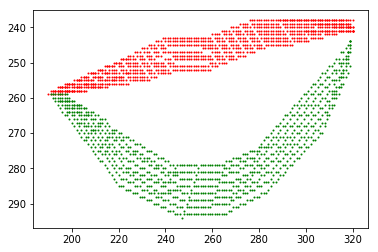

In [313]:
plt.scatter(lx1,ly1,1,color='r')
plt.scatter(lx2,ly2,1,color='g')
plt.gca().invert_yaxis() # reverse axis as the image
plt.show()

In [407]:
new_img = add_color(img.copy(),1,lx1+lx2,ly1+ly2,rgb=(100,100,100))

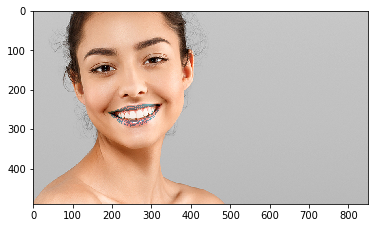

In [408]:
plt.imshow(new_img)

In [409]:
def fill_lip_solid(image,outer, inner,rgb=(100,100,100)):
        """ Fills solid colour inside two outlines. """
        red_l,green_l,blue_l = rgb
        inner[0].reverse()
        inner[1].reverse()
        outer_curve = zip(outer[0], outer[1])
        inner_curve = zip(inner[0], inner[1])
        points = []
        for point in outer_curve:
            points.append(np.array(point, dtype=np.int32))
        for point in inner_curve:
            points.append(np.array(point, dtype=np.int32))
        points = np.array(points, dtype=np.int32)
        red_l = int(red_l)
        green_l = int(green_l)
        blue_l = int(blue_l)
        cv2.fillPoly(image, [points], (red_l, green_l, blue_l))
        return image

In [410]:
new_img = fill_lip_solid(img.copy(),uol_curve,uil_curve)

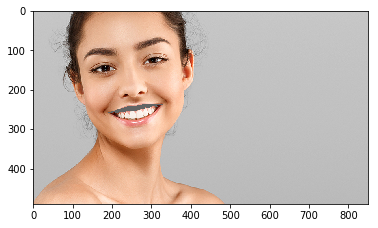

In [411]:
plt.imshow(new_img)

In [ ]:
def __smoothen_color(outer, inner):
        """ Smoothens and blends colour applied between a set of outlines. """
        outer_curve = zip(outer[0], outer[1])
        inner_curve = zip(inner[0], inner[1])
        x_points = []
        y_points = []
        for point in outer_curve:
            x_points.append(point[0])
            y_points.append(point[1])
        for point in inner_curve:
            x_points.append(point[0])
            y_points.append(point[1])
        img_base = np.zeros((self.height, self.width))
        cv2.fillConvexPoly(img_base, np.array(np.c_[x_points, y_points], dtype='int32'), 1)
        img_mask = cv2.GaussianBlur(img_base, (81, 81), 0) #51,51
        img_blur_3d = np.ndarray([self.height, self.width, 3], dtype='float')
        img_blur_3d[:, :, 0] = img_mask
        img_blur_3d[:, :, 1] = img_mask
        img_blur_3d[:, :, 2] = img_mask
        im_copy = (img_blur_3d * self.image * 0.7 + (1 - img_blur_3d * 0.7) * self.im_copy).astype('uint8')

In [278]:
__fill_lip_lines(uol_c, uil_c)
__fill_lip_lines(lol_c, lil_c)
__add_color(1)
fill_lip_solid(uol_c, uil_c)
__fill_lip_solid(lol_c, lil_c)
__smoothen_color(uol_c, uil_c)
__smoothen_color(lol_c, lil_c)

NameError: name 'self' is not defined

In [ ]:
def __add_color(self, intensity):
        """ Adds base colour to all points on lips, at mentioned intensity. """
        val = color.rgb2lab(
            (image[lip_y, self.lip_x] / 255.)
            .reshape(len(self.lip_y), 1, 3)
        ).reshape(len(self.lip_y), 3)
        l_val, a_val, b_val = np.mean(val[:, 0]), np.mean(val[:, 1]), np.mean(val[:, 2])
        l1_val, a1_val, b1_val = color.rgb2lab(
            np.array(
                (self.red_l / 255., self.green_l / 255., self.blue_l / 255.)
                ).reshape(1, 1, 3)
            ).reshape(3,)
        l_final, a_final, b_final = (l1_val - l_val) * \
            intensity, (a1_val - a_val) * \
            intensity, (b1_val - b_val) * intensity
        val[:, 0] = np.clip(val[:, 0] + l_final, 0, 100)
        val[:, 1] = np.clip(val[:, 1] + a_final, -127, 128)
        val[:, 2] = np.clip(val[:, 2] + b_final, -127, 128)
        self.image[self.lip_y, self.lip_x] = color.lab2rgb(val.reshape(
            len(self.lip_y), 1, 3)).reshape(len(self.lip_y), 3) * 255

In [22]:
def init():
        """ Initiator method for class """
        DetectLandmarks.__init__(self)
        self.red_l = 0
        self.green_l = 0
        self.blue_l = 0
        self.red_e = 0
        self.green_e = 0
        self.blue_e = 0
        self.debug = 0
        self.image = 0
        self.width = 0
        self.height = 0
        self.im_copy = 0
        self.lip_x = []
        self.lip_y = []

In [10]:
def __read_image(self, filename):
        """ Read image from path forwarded """
        self.image = cv2.imread(filename)
        self.image = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
        self.im_copy = self.image.copy()
        self.height, self.width = self.image.shape[:2]
        self.debug = 0
        

In [11]:
def __draw_curve(self, points):
        """ Draws a curve alone the given points by creating an interpolated path. """
        x_pts = []
        y_pts = []
        curvex = []
        curvey = []
        self.debug += 1
        for point in points:
            x_pts.append(point[0])
            y_pts.append(point[1])
        curve = scipy.interpolate.interp1d(x_pts, y_pts, 'cubic')
        if self.debug == 1 or self.debug == 2:
            for i in np.arange(x_pts[0], x_pts[len(x_pts) - 1] + 1, 1):
                curvex.append(i)
                curvey.append(int(curve(i)))
        else:
            for i in np.arange(x_pts[len(x_pts) - 1] + 1, x_pts[0], 1):
                curvex.append(i)
                curvey.append(int(curve(i)))
        return curvex, curvey

In [12]:
def __fill_lip_lines(self, outer, inner):
        """ Fills the outlines of a lip with colour. """
        outer_curve = zip(outer[0], outer[1])
        inner_curve = zip(inner[0], inner[1])
        count = len(inner[0]) - 1
        last_inner = [inner[0][count], inner[1][count]]
        for o_point, i_point in itertools.zip_longest(
                outer_curve, inner_curve, fillvalue=last_inner
            ):
            line = scipy.interpolate.interp1d(
                [o_point[0], i_point[0]], [o_point[1], i_point[1]], 'linear')
            xpoints = list(np.arange(o_point[0], i_point[0], 1))
            self.lip_x.extend(xpoints)
            self.lip_y.extend([int(point) for point in line(xpoints)])
        return

In [13]:
def __fill_lip_solid(self, outer, inner):
        """ Fills solid colour inside two outlines. """
        inner[0].reverse()
        inner[1].reverse()
        outer_curve = zip(outer[0], outer[1])
        inner_curve = zip(inner[0], inner[1])
        points = []
        for point in outer_curve:
            points.append(np.array(point, dtype=np.int32))
        for point in inner_curve:
            points.append(np.array(point, dtype=np.int32))
        points = np.array(points, dtype=np.int32)
        self.red_l = int(self.red_l)
        self.green_l = int(self.green_l)
        self.blue_l = int(self.blue_l)
        cv2.fillPoly(self.image, [points], (self.red_l, self.green_l, self.blue_l))

In [14]:
def __smoothen_color(self, outer, inner):
        """ Smoothens and blends colour applied between a set of outlines. """
        outer_curve = zip(outer[0], outer[1])
        inner_curve = zip(inner[0], inner[1])
        x_points = []
        y_points = []
        for point in outer_curve:
            x_points.append(point[0])
            y_points.append(point[1])
        for point in inner_curve:
            x_points.append(point[0])
            y_points.append(point[1])
        img_base = np.zeros((self.height, self.width))
        cv2.fillConvexPoly(img_base, np.array(np.c_[x_points, y_points], dtype='int32'), 1)
        img_mask = cv2.GaussianBlur(img_base, (81, 81), 0) #51,51
        img_blur_3d = np.ndarray([self.height, self.width, 3], dtype='float')
        img_blur_3d[:, :, 0] = img_mask
        img_blur_3d[:, :, 1] = img_mask
        img_blur_3d[:, :, 2] = img_mask
        self.im_copy = (img_blur_3d * self.image * 0.7 + (1 - img_blur_3d * 0.7) * self.im_copy).astype('uint8')

In [15]:
def __draw_liner(self, eye, kind):
        """ Draws eyeliner. """
        eye_x = []
        eye_y = []
        x_points = []
        y_points = []
        for point in eye:
            x_points.append(int(point.split()[0]))
            y_points.append(int(point.split()[1]))
        curve = scipy.interpolate.interp1d(x_points, y_points, 'quadratic')
        for point in np.arange(x_points[0], x_points[len(x_points) - 1] + 1, 1):
            eye_x.append(point)
            eye_y.append(int(curve(point)))
        if kind == 'left':
            y_points[0] -= 1
            y_points[1] -= 1
            y_points[2] -= 1
            x_points[0] -= 5
            x_points[1] -= 1
            x_points[2] -= 1
            curve = scipy.interpolate.interp1d(x_points, y_points, 'quadratic')
            count = 0
            for point in np.arange(x_points[len(x_points) - 1], x_points[0], -1):
                count += 1
                eye_x.append(point)
                if count < (len(x_points) / 2):
                    eye_y.append(int(curve(point)))
                elif count < (2 * len(x_points) / 3):
                    eye_y.append(int(curve(point)) - 1)
                elif count < (4 * len(x_points) / 5):
                    eye_y.append(int(curve(point)) - 2)
                else:
                    eye_y.append(int(curve(point)) - 3)
        elif kind == 'right':
            x_points[3] += 5
            x_points[2] += 1
            x_points[1] += 1
            y_points[3] -= 1
            y_points[2] -= 1
            y_points[1] -= 1
            curve = scipy.interpolate.interp1d(x_points, y_points, 'quadratic')
            count = 0
            for point in np.arange(x_points[len(x_points) - 1], x_points[0], -1):
                count += 1
                eye_x.append(point)
                if count < (len(x_points) / 2):
                    eye_y.append(int(curve(point)))
                elif count < (2 * len(x_points) / 3):
                    eye_y.append(int(curve(point)) - 1)
                elif count < (4 * len(x_points) / 5):
                    eye_y.append(int(curve(point)) - 2)
                elif count:
                    eye_y.append(int(curve(point)) - 3)
        curve = zip(eye_x, eye_y)
        points = []
        for point in curve:
            points.append(np.array(point, dtype=np.int32))
        points = np.array(points, dtype=np.int32)
        self.red_e = int(self.red_e)
        self.green_e = int(self.green_e)
        self.blue_e = int(self.blue_e)
        cv2.fillPoly(self.im_copy, [points], (self.red_e, self.green_e, self.blue_e))
        return

In [16]:
def __get_points_lips(self, lips_points):
        """ Get the points for the lips. """
        uol = []
        uil = []
        lol = []
        lil = []
        for i in range(0, 14, 2):
            uol.append([int(lips_points[i]), int(lips_points[i + 1])])
        for i in range(12, 24, 2):
            lol.append([int(lips_points[i]), int(lips_points[i + 1])])
        lol.append([int(lips_points[0]), int(lips_points[1])])
        for i in range(24, 34, 2):
            uil.append([int(lips_points[i]), int(lips_points[i + 1])])
        for i in range(32, 40, 2):
            lil.append([int(lips_points[i]), int(lips_points[i + 1])])
        lil.append([int(lips_points[24]), int(lips_points[25])])
        return uol, uil, lol, lil

In [17]:
def __get_curves_lips(self, uol, uil, lol, lil):
        """ Get the outlines of the lips. """
        uol_curve = self.__draw_curve(uol)
        uil_curve = self.__draw_curve(uil)
        lol_curve = self.__draw_curve(lol)
        lil_curve = self.__draw_curve(lil)
        return uol_curve, uil_curve, lol_curve, lil_curve

In [18]:
def __fill_color(self, uol_c, uil_c, lol_c, lil_c):
        """ Fill colour in lips. """
        self.__fill_lip_lines(uol_c, uil_c)
        self.__fill_lip_lines(lol_c, lil_c)
        self.__add_color(1)
        self.__fill_lip_solid(uol_c, uil_c)
        self.__fill_lip_solid(lol_c, lil_c)
        self.__smoothen_color(uol_c, uil_c)
        self.__smoothen_color(lol_c, lil_c)

In [19]:
def __create_eye_liner(self, eyes_points):
        """ Apply eyeliner. """
        left_eye = eyes_points[0].split('\n')
        right_eye = eyes_points[1].split('\n')
        right_eye = right_eye[0:4]
        self.__draw_liner(left_eye, 'left')
        self.__draw_liner(right_eye, 'right')

In [20]:
def apply_lipstick(self, filename, rlips, glips, blips):
        """
        Applies lipstick on an input image.
        ___________________________________
        Args:
            1. `filename (str)`: Path for stored input image file.
            2. `red (int)`: Red value of RGB colour code of lipstick shade.
            3. `blue (int)`: Blue value of RGB colour code of lipstick shade.
            4. `green (int)`: Green value of RGB colour code of lipstick shade.

        Returns:
            `filepath (str)` of the saved output file, with applied lipstick.

        """

        self.red_l = rlips
        self.green_l = glips
        self.blue_l = blips
        self.__read_image(filename)
        lips = self.get_lips(self.image)
        lips = list([point.split() for point in lips.split('\n')])
        lips_points = [item for sublist in lips for item in sublist]
        uol, uil, lol, lil = self.__get_points_lips(lips_points)
        uol_c, uil_c, lol_c, lil_c = self.__get_curves_lips(uol, uil, lol, lil)
        self.__fill_color(uol_c, uil_c, lol_c, lil_c)
        self.im_copy = cv2.cvtColor(self.im_copy, cv2.COLOR_BGR2RGB)
        name = 'color_' + str(self.red_l) + '_' + str(self.green_l) + '_' + str(self.blue_l)
        file_name = 'output_' + name + '.jpg'
        cv2.imwrite(file_name, self.im_copy)
        return file_name

In [21]:
def apply_liner(self, filename):
        """
        Applies lipstick on an input image.
        ___________________________________
        Args:
            1. `filename (str)`: Path for stored input image file.

        Returns:
            `filepath (str)` of the saved output file, with applied lipstick.

        """
        self.__read_image(filename)
        liner = self.get_upper_eyelids(self.image)
        eyes_points = liner.split('\n\n')
        self.__create_eye_liner(eyes_points)
        self.im_copy = cv2.cvtColor(self.im_copy, cv2.COLOR_BGR2RGB)
        name = '_color_' + str(self.red_l) + '_' + str(self.green_l) + '_' + str(self.blue_l)
        file_name = 'output_' + name + '.jpg'
        cv2.imwrite(file_name, self.im_copy)
        return file_name